# Python notebook 

## In memory approach as opposed to a database
Amazon co-purchase data analysis


In [239]:
import matplotlib.pyplot as plt
import networkx as nx
import pickle
import pandas as pd
from neo4jrestclient.client import GraphDatabase
from neo4jrestclient.constants import RAW
from neo4jrestclient.client import Node 

In [240]:
file = 'C:/Users/moore/Dropbox/graphs/Amazon0601.txt'
location_gml = 'C:/Users/moore/Dropbox/graphs/Amazon.gml'
location_pickle = 'C:/Users/moore/Dropbox/graphs/Amazon.gpickle'
file_meta = 'C:/Users/moore/Dropbox/graphs/Amazon-meta.txt'
pickle_meta = 'C:/Users/moore/Dropbox/graphs/AmazonMeta.p'
location_pairs = 'C:/Users/moore/Dropbox/graphs/Amazon.p'

review_csv = 'C:/Users/moore/Dropbox/graphs/reviews.csv'
sims_csv = 'C:/Users/moore/Dropbox/graphs/sims.csv'
prods_csv = 'C:/Users/moore/Dropbox/graphs/prods.csv'
bought_csv = 'C:/Users/moore/Dropbox/graphs/bought.csv'
cats_csv = 'C:/Users/moore/Dropbox/graphs/cats.csv'
prods_csv = 'C:/Users/moore/Dropbox/graphs/prods_dataframe.csv'
product_details = 'C:/Users/moore/Dropbox/graphs/prods_data.p'
pair_listing = 'C:/Users/moore/Dropbox/graphs/pair_list.p'
pair_dictionary = 'C:/Users/moore/Dropbox/graphs/pair_dict.p'

In [241]:
def in_memory():
    restructured = pickle.load(open(product_details, 'rb'))
    pair_dict = pickle.load(open(pair_dictionary, 'rb'))
    paths = pickle.load(open(pair_listing, 'rb')) 
    records = []
    for path in paths:
        dic = {}
        pairs = (path[0],path[1])
        try:
            a = pair_dict[pairs[1]]
        except:
            a = 0
        dic = {'Title': restructured[pairs[0]]['title'], 
           'co_purNum': pair_dict[pairs[0]], 
           'pair Title': restructured[pairs[1]]['title'], 
           'pair_Count': a}
        records.append(dic)
    
    df = pd.DataFrame.from_records(records)
    return df.shape

In [242]:
def neo4j():
    from neo4jrestclient.client import GraphDatabase
    from neo4jrestclient.constants import RAW
    from neo4jrestclient.client import Node 
    q = """MATCH p=(n)-[r:co_pur]->(w) RETURN n.title, n.id, n.cats, n.status, w.title, w.id, w.cats, w.status"""
    db = GraphDatabase("http://localhost:7474/db/data")
    #retrieve a list of all nodes with the labels
    params = {}
    results = db.query(q, params=params, returns=RAW)
    records = []
    for prod in results:
        records.append(prod)
    
    cols = ['n.title', 'n.id', 'n.cats', 'n.status', 'w.title', 'w.id', 'w.cats', 'w.status']
    df = pd.DataFrame.from_records(records, columns=cols)  
    return df.shape

In [243]:
%%time
shape=in_memory()
print(shape, 'returned from in-memory approach ')

(3387388, 4) returned from in-memory approach 
Wall time: 9.99 s


In [244]:
%%time
shape=neo4j()
print(shape, 'returned from Cypher query on local Neo4j database')

(3387388, 8) returned from Cypher query on local Neo4j database
Wall time: 53.7 s


In [245]:
q = """MATCH p=(n:Product) OPTIONAL MATCH (n)-[r:co_pur]->() RETURN n.id, n.status, n.sales_rank, count(r);"""

In [246]:
def neo4(q):
    from neo4jrestclient.client import GraphDatabase
    from neo4jrestclient.constants import RAW
    from neo4jrestclient.client import Node 
    db = GraphDatabase("http://localhost:7474/db/data")
    #retrieve a list of all nodes with the labels
    params = {}
    results = db.query(q, params=params, returns=RAW)
    records = []
    for prod in results:
        records.append(prod)  
    return records    

In [267]:
q = """MATCH p=(n:Product) OPTIONAL MATCH (n)-[r:co_pur]->() RETURN n.id, n.status, n.sales_rank, count(r);"""
records = neo4(q)
cols = ['n.id', 'n.status', 'n.sales_rank', 'count_sim']
df = pd.DataFrame.from_records(records, columns=cols)  

In [268]:
df.head()

,n.id,n.status,n.sales_rank,count_sim
0,0684839385,active,1578,10
1,0375431500,active,712907,3
2,B000007WEG,active,114054,10
3,B00004TUS6,active,163174,10
4,0307106519,active,994870,7


In [269]:
df['count_sim'] = df['count_sim'].fillna(0)
df['n.sales_rank'] = df['n.sales_rank'].fillna(0)

In [270]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 548552 entries, 0 to 548551
Data columns (total 4 columns):
n.id            548552 non-null object
n.status        548552 non-null object
n.sales_rank    548552 non-null object
count_sim       548552 non-null int64
dtypes: int64(1), object(3)
memory usage: 16.7+ MB


In [271]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df['n.sales_rank'].values.reshape(-1, 1))
df['scaled'] = scaled

C:\Users\moore\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [272]:
df['scaled'].describe()

count    548552.000000
mean          0.127448
std           0.149254
min           0.000000
25%           0.022571
50%           0.077478
75%           0.175329
max           1.000000
Name: scaled, dtype: float64

In [273]:
df['scaled'] = df.scaled.apply(lambda x: (x*100)).astype(int)

In [274]:
df.head()

,n.id,n.status,n.sales_rank,count_sim,scaled
0,0684839385,active,1578,10,0
1,0375431500,active,712907,3,18
2,B000007WEG,active,114054,10,3
3,B00004TUS6,active,163174,10,4
4,0307106519,active,994870,7,26


In [275]:
summ = df.groupby('scaled')['count_sim'].mean()

In [277]:
q = """MATCH p=(n:Product) OPTIONAL MATCH (n)-[r:similar]->() RETURN n.id, n.status, n.avg_rating, count(r);"""
records = neo4(q)
cols = ['n.id', 'n.status', 'n.avg_rating', 'count_sim']
df = pd.DataFrame.from_records(records, columns=cols)  
df['count_sim'] = df['count_sim'].fillna(0)
df['n.avg_rating'] = df['n.avg_rating'].fillna(0)
summ2 = df.groupby('n.avg_rating')['count_sim'].mean()


In [278]:
q = """MATCH p=(n:Product) OPTIONAL MATCH (n)-[r:similar]->() RETURN n.id, n.status, n.sales_rank, count(r);"""
records = neo4(q)
cols = ['n.id', 'n.status', 'n.sales_rank', 'count_sim']
df = pd.DataFrame.from_records(records, columns=cols)  
df['count_sim'] = df['count_sim'].fillna(0)
df['n.sales_rank'] = df['n.sales_rank'].fillna(0)
scaled = scaler.fit_transform(df['n.sales_rank'].values.reshape(-1, 1))
df['scaled'] = scaled
df['scaled'] = df.scaled.apply(lambda x: (x*100)).astype(int)
summ1 = df.groupby('scaled')['count_sim'].mean()

C:\Users\moore\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [290]:
q = """MATCH p=(n:Product) OPTIONAL MATCH (n)-[r:co_pur]->() RETURN n.id, n.status, n.avg_rating, count(r);"""
records = neo4(q)
cols = ['n.id', 'n.status', 'n.avg_rating', 'count_sim']
df = pd.DataFrame.from_records(records, columns=cols)  
df['count_sim'] = df['count_sim'].fillna(0)
df['n.avg_rating'] = df['n.avg_rating'].fillna(0)
summ3 = df.groupby('n.avg_rating')['count_sim'].mean()

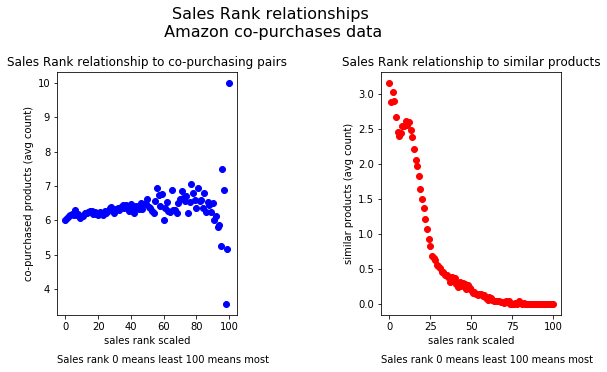

In [285]:
f, (ax1, ax2) = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(10,5))
ax1.plot(summ, 'bo')
ax1.set_xlabel("sales rank scaled")
ax1.set_ylabel("co-purchased products (avg count)")
ax1.set_title("Sales Rank relationship to co-purchasing pairs")
ax1.annotate('Sales rank 0 means least 100 means most', (0,0), (0, -40), xycoords='axes fraction', textcoords='offset points', va='top')
ax2.plot(summ1, 'ro')
ax2.set_xlabel("sales rank scaled")
ax2.set_ylabel("similar products (avg count)")
ax2.set_title("""Sales Rank relationship to similar products""")
plt.subplots_adjust(left=0.2, wspace=0.8, top=0.8)
plt.suptitle("""Sales Rank relationships \n Amazon co-purchases data \n\n""", fontsize=16)
ax2.annotate('Sales rank 0 means least 100 means most', (0,0), (0, -40), xycoords='axes fraction', textcoords='offset points', va='top')
plt.show()

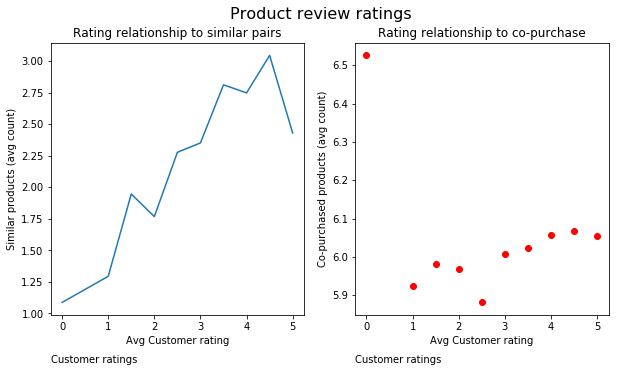

In [300]:
f, (ax1, ax2) = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(10,5))
plt.suptitle("""Product review ratings""", fontsize=16)
ax1.plot(summ2)
ax1.set_xlabel("Avg Customer rating")
ax1.set_ylabel("Similar products (avg count)")
ax1.set_title("Rating relationship to similar pairs")
ax1.annotate('Customer ratings', (0,0), (0, -40), xycoords='axes fraction', textcoords='offset points', va='top')
ax2.plot(summ3, 'ro')
ax2.set_xlabel("Avg Customer rating")
ax2.set_ylabel("Co-purchased products (avg count)")
ax2.set_title("Rating relationship to co-purchase")
ax2.annotate('Customer ratings', (0,0), (0, -40), xycoords='axes fraction', textcoords='offset points', va='top')
plt.show()